#  Yelp Recommender System

### Clara De Paolis Kaluza

### CS6220-03 Final Project
### Fall 2016

## The Data: Exploratory data analysis and pre-processing

The Yelp Dataset Challenge dataset provides information on a subset of its   
- users  
- businesses  
- reviews and ratings   
- tips  
- check-ins

It includes data from 10 cities worldwide, but the size of the data from each city differs widely

e.g. there are 36,500 businesses in Las Vegas, but only 530 in Toronto

To build a recommendation system, we first must clean the data and establish a clear goal for recommendations

### Data summary
The Yelp Dataset Challenge data offers a rich collection of data about businesses and users on Yelp. These data include information about users, businesses, reviews, user ratings, and other information collected by Yelp, such as user "tips" for businesses and counts of user "check-ins" to businesses. 

The dataset includes businesses and users from ten cities in North American and Europe. These include Edinburgh, U.K., Karlsruhe, Germany, Montreal and  Waterloo, Canada, and six cities in the U.S. The number of businesses, users, and reviews in each cities is not uniform. For example, the dataset includes 36,500 businesses in Las Vegas, but only 530 in Toronto. As a starting point for this project, one city will be chosen to build the recommender system. The city will be chosen to maximize available data. The selection criteria is yet to be determined, but possible choices are the maximum number of businesses, the maximum number of reviews and tips, or the maximum number of check-ins.


User data includes information about the each user's account, such as the account creation date, the number of reviews generated by the user, the average rating given by the user, the user's "friends," "compliments" from other users, and votes from other users on reviews written by the user. In addition, each review and tip is linked to the user who wrote the review or tip. Business data includes information about the business category, location, hours of operation, average rating, number of reviews, the count of user check-in by date (though the specific user ID for each check-in is not provided), and lastly every review is linked to the business for which it was written. All these data will be used to construct features to capture business-business and user-user similarities.

In [1]:
# Load the data
import json
import pandas as pd

def json_to_df(file_name):
    # parse json file into pandas dataframe
    
    # read file line-by-line to get individual json objects
    with open(file_name) as file_IO:
        file_list = file_IO.readlines()
    
    #parse json objects into dictionaries 
    list_of_dicts = [json.loads(line) for line in file_list]
    
    df = pd.DataFrame(list_of_dicts)
    return df

# Data files
tip_file = 'yelp_academic_dataset_tip.json'
user_file = 'yelp_academic_dataset_user.json'
review_file = 'yelp_academic_dataset_review.json'
checkin_file = 'yelp_academic_dataset_checkin.json'
business_file = 'yelp_academic_dataset_business.json'
    
tip_df = json_to_df(tip_file)
user_df = json_to_df(user_file)
review_df = json_to_df(review_file)
checkin_df = json_to_df(checkin_file)
business_df = json_to_df(business_file)

### Filtering and selecting the dataset

There are many types of businesses categories in the dataset. These categories are included as tags in the data and businesses can have multiple tags.

We are specifically interested in recommending resturants to users of one city. The Yelp Dataset Challenge data contains data for users in many cities around the world and of many different types of businesses. To build the best recommender system, we are interested in using the most data alailable, so we use the city that has the most businesses, reviews, and users. To this end, we explore the data to find the best city with which to work and then filter our data. Filtering the data will also lower the processing and storage demands of the application.

First we find the total number of businesses in the dataset. This count includes restaurants and non-restaurant businesses in all cities in the dataset.

In [2]:
# Number of business in total
business_df['business_id'].count()

85901

#### Business Category
To get an idea of the types of busineesses included in the dataset, we can look at the "Categories" tag in the Businesses table.   

In [3]:
import itertools
from collections import Counter


def filter_businesses(dataframe, key, value):
    # Return business ID of businesses tagged as restaurants
    business_ids = dataframe.loc[dataframe[key].apply(lambda df: value in df and value != '')]['business_id']
    return business_ids
    
def common_categories(dataframe):
    # find the most common categories of businesses
    all_categories = list(itertools.chain.from_iterable(list(dataframe['categories'])))
    num_categories = len(set(all_categories))
    top_categories = Counter(all_categories).most_common(20)
    return all_categories, num_categories, top_categories

In [4]:
    
categories, num_categories, top_categories = common_categories(business_df)

print("There are {} unique business categories in the dataset".format(num_categories))
print("The top categories by count are")
print('\n'.join('\t{}:{}'.format(*k) for i,k in enumerate(top_categories)))

There are 1017 unique business categories in the dataset
The top categories by count are
	Restaurants:26729
	Shopping:12444
	Food:10143
	Beauty & Spas:7490
	Health & Medical:6106
	Home Services:5866
	Nightlife:5507
	Automotive:4888
	Bars:4727
	Local Services:4041
	Active Life:3455
	Fashion:3395
	Event Planning & Services:3237
	Fast Food:3154
	Pizza:2881
	Mexican:2705
	Hotels & Travel:2673
	Sandwiches:2666
	American (Traditional):2608
	Arts & Entertainment:2447


#### Location

Next, we explore the data to select the best city with which to work. Because many cities are actually larger metropolitan areas that include several cities, we divide the data by state and look at the counts by state. We would like choose a location that has the most businesses, and restaurants in particular, but also has the most reviews for those businesses (restaurants).

In [5]:
def data_location(input_dataframe, businesses_dataframe):
    # Count businesses in input_dataframe by state
    #  the businesses_dataframe contains the business_id and the location of the business
    #  the input_dataframe contains the business_id and other information (reviews, checkins, tips, etc)
    
    data_per_business = dict(Counter(list(input_dataframe['business_id'].values)))
    restaurant_ids = filter_businesses(businesses_dataframe, key='categories', value='Restaurants')
    
    location_counts = {state:{'all':0, 'restaurants':0} for state in businesses_dataframe['state'].unique()}
    for state in location_counts:
        state_businesses = set(filter_businesses(businesses_dataframe, key='state', value=state))
        state_restaurants = set(state_businesses).intersection(set(restaurant_ids))
        
        all_businesses_counts = [count for business_id, count in data_per_business.items() if business_id in state_businesses]
        restaurants_counts    = [count for business_id, count in data_per_business.items() if business_id in state_restaurants]
        
        location_counts[state]['all'] = sum(all_businesses_counts)
        location_counts[state]['restaurants'] = sum(restaurants_counts)
    
    # sort by restaurant count
    top_restaurant_counts = sorted(location_counts.items(), key=lambda x: x[1]['restaurants'], reverse=True)

    return location_counts,top_restaurant_counts


In [6]:
# Business counts
business_location_counts, top_restaurant_counts = data_location(business_df, business_df)
print("Number of all business and restaurant by state")
print('\n'.join('\t{}:{}'.format(*k) for i,k in enumerate(top_restaurant_counts[:12])))

# Reviews counts
review_location_counts, top_restaurant_review_counts = data_location(review_df, business_df)
print("Number of reviews for all business and restaurant by state")
print('\n'.join('\t{}:{}'.format(*k) for i,k in enumerate(top_restaurant_review_counts[:12])))

# Check-in counts
checkin_location_counts, top_restaurant_checkin_counts = data_location(checkin_df, business_df)
print("Number of check-ins for all business and restaurant by state")
print('\n'.join('\t{}:{}'.format(*k) for i,k in enumerate(top_restaurant_checkin_counts[:12])))

# Tip counts
tips_location_counts, top_restaurant_tips_counts = data_location(tip_df, business_df)
print("Number of tips for all business and restaurant by state")
print('\n'.join('\t{}:{}'.format(*k) for i,k in enumerate(top_restaurant_tips_counts[:12])))

Number of all business and restaurant by state
	AZ:{'all': 36500, 'restaurants': 9427}
	NV:{'all': 23591, 'restaurants': 5912}
	QC:{'all': 5591, 'restaurants': 3385}
	NC:{'all': 6835, 'restaurants': 2421}
	PA:{'all': 4086, 'restaurants': 1671}
	EDH:{'all': 3297, 'restaurants': 1232}
	WI:{'all': 3066, 'restaurants': 1172}
	BW:{'all': 1055, 'restaurants': 571}
	ON:{'all': 530, 'restaurants': 372}
	IL:{'all': 808, 'restaurants': 317}
	SC:{'all': 327, 'restaurants': 143}
	MLN:{'all': 161, 'restaurants': 75}
Number of reviews for all business and restaurant by state
	NV:{'all': 1154799, 'restaurants': 662428}
	AZ:{'all': 1029103, 'restaurants': 622446}
	NC:{'all': 165625, 'restaurants': 112794}
	PA:{'all': 111542, 'restaurants': 78754}
	QC:{'all': 88046, 'restaurants': 63987}
	WI:{'all': 69917, 'restaurants': 49243}
	EDH:{'all': 30003, 'restaurants': 15189}
	IL:{'all': 19045, 'restaurants': 13054}
	ON:{'all': 5854, 'restaurants': 4814}
	SC:{'all': 5004, 'restaurants': 3532}
	BW:{'all': 3721

Nevada and Arizona are both at the top of the counts for all the data sources (number of restaurants, number of reviews, number of check-ins, and number of tips). However, Arizona has about 60% more restaurants than does Nevada. Therefore, we will choose to first focus on Arizona restaurants. To do so, we will filter our data to include only data from Arizona. We will consider a user to be in Arizona if they have ever reviewed, checked-in, or submitted a tip for a restaurant in Arizona.

In [7]:
def filter_data(users_dataframe, businesses_dataframe, reviews_dataframe, state):
    # Find user IDs for users that have interacted with businesses (restaurants) 
    # that meet criteria in key
    restaurant_ids = filter_businesses(businesses_dataframe, key='categories', value='Restaurants')
    state_restaurants = filter_businesses(businesses_dataframe.loc[businesses_dataframe['business_id'].isin(restaurant_ids)], key='state', value=state)
    
    reviews = reviews_dataframe.loc[reviews_dataframe['business_id'].isin(state_restaurants)]
    return reviews
state = 'PA'    
state_reviews = filter_data(user_df,business_df, review_df, state)               

In [8]:
#After filtering the data, delete old data (save memory)
del review_df
del business_df

### Time
To train and evaluate the recommender system, the dateset must be split by time. The first time period is used to train the recommender system and the later time period is used to evaluate it. To find the appropriate train-test split, the number of reviews over time is analyzed

In [9]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.dates
%matplotlib inline
import numpy as np
import datetime

# convert date strings to datetime objects
datetimes = pd.to_datetime(state_reviews['date'],format='%Y-%m-%d').astype(datetime.datetime)
state_reviews['date'] = datetimes

# For plotting and counting, functions to change object types for dates
to_timestamp = np.vectorize(lambda x: (x - datetime.datetime(1970, 1, 1)).total_seconds())
from_timestamp = np.vectorize(lambda x: datetime.datetime.utcfromtimestamp(x))

# Count reviews per month and cummulative counts
counts, bin_edges = np.histogram(to_timestamp(datetimes),bins=len(set([dt.year for dt in datetimes]))*12)
cummulative_counts = [sum(counts[:i+1]) for i,count in enumerate(counts)]

# Split at time so that ~80% is used to train and the remaining ~20% is used to test
idx = np.where(np.abs(np.array(cummulative_counts)- int(0.8*cummulative_counts[-1]))==np.min(np.abs(np.array(cummulative_counts)- int(0.8*cummulative_counts[-1]))))
cutoff = from_timestamp(bin_edges[idx])[0]

In [10]:
def plot_reviews_over_time(counts, cummulative_counts, bin_edges, cutoff):
    fig, ax = plt.subplots(1,1,figsize=(12,6))
    color1 = next(ax._get_lines.prop_cycler)['color']
    color2 = next(ax._get_lines.prop_cycler)['color']
    ax2 = ax.twinx()
    ax.plot([dt.date() for dt in from_timestamp(bin_edges)[1:]],counts,color=color1,label='counts')
    l=plt.axvline(x=cutoff, linewidth=2,color='black')
    ax2.plot([dt.date() for dt in from_timestamp(bin_edges)[:-1]],cummulative_counts,color=color2,label='cummulative')
    plt.title('Number of reviews per month')
    ax.xaxis_date()

    ax.set_ylabel('count by month',color=color1)
    ax2.set_ylabel('cummulative',color=color2)
    ax.set_xlabel('Year')
    ax.grid(0)
    ax2.grid(0)
    #return ax,ax2

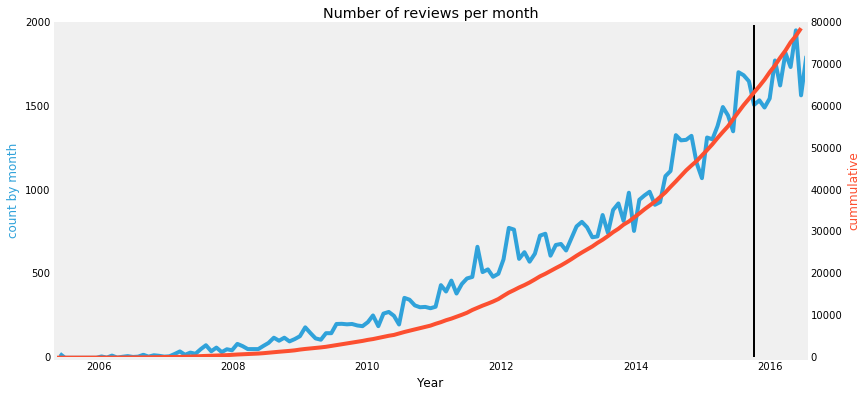

In [11]:
plot_reviews_over_time(counts, cummulative_counts, bin_edges, cutoff)

In [12]:
def split_dataframe(dataframe, cutoff, threhold_column):
    # split dataframe into two dataframes accoring to some threshold
    # first dataframe returned will include all records that are below cutoff in the threshold_column
    # second dataframe returned will include all records that are above or equal to cutoff in the threshold_column
    below = dataframe[dataframe[threhold_column]<cutoff]    
    above = dataframe[dataframe[threhold_column]>=cutoff]    
    return below, above

train_records, test_records = split_dataframe(state_reviews, cutoff, 'date')

## Utility Matrix

### Constructing the utility matrix

if $r_{ij}$ is the rating user $i$ gave item $j$,

$$
R_{ij} =
\left\{
\begin{array}{ll}
      r_{ij} & \text{if user $i$ reviewed item $j$} \\
      0 & \mathrm{otherwise} \\
\end{array} 
\right.
$$


In [13]:
import scipy.sparse
import scipy.sparse.linalg

In [14]:
def index_entries(reviews):
    # create indices for businesses and users in dataset
    # these look-up tables are used to convert between 
    business_indx_lookup = {b_id:int(idx) for idx,b_id in enumerate(state_reviews['business_id'].unique())}
    user_indx_lookup = {u_id:int(idx) for idx,u_id in enumerate(state_reviews['user_id'].unique())}
    business_id_lookup = {int(idx):b_id for b_id,idx in business_indx_lookup.items()}
    user_id_lookup = {int(idx):u_id for u_id,idx in user_indx_lookup.items()}
    
    return business_indx_lookup, user_indx_lookup, business_id_lookup, user_id_lookup
    

def utility_matrix(dataframe, item_indx_lookup, user_indx_lookup):
    # construct utility matrix
    n,m = len(user_indx_lookup),len(item_indx_lookup)
    
    # get indices and star ratings from dataframe
    U = [[user_indx_lookup[u_id],item_indx_lookup[b_id],s] for 
     u_id,b_id,s in dataframe[['user_id','business_id','stars']].to_records(index=False)]
    user, business, stars = zip(*U)
    
    # construct sparse matrix with coordintates (user index, business index) and value equal to the rating
    coo = scipy.sparse.coo_matrix((stars,(user,business)),shape=[n,m],dtype=np.int8)
    # to override summing entries with the same user and business indices, 
    # convert data to dict of keys sparce matrix:
    dok = scipy.sparse.dok_matrix((coo.shape),dtype=np.int8)
    dok.update(zip(zip(coo.row,coo.col),coo.data))
    utility_matrix = scipy.sparse.csr_matrix(dok)
    return utility_matrix

In [15]:
def plot_sparse_matrix(matrix):
    
    sparcity = (len(matrix.nonzero()[0])/(matrix.shape[0]*matrix.shape[1]))
    
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(111)
    ax.spy(matrix, markersize=0.05, precision=0.1, aspect='auto')
    plt.ylabel('businesses')
    plt.xlabel('users')
    title='Utility matrix nonzeros ({:.2%})'.format(sparcity)
    plt.title(title)
    plt.show()

def plot_review_counts(matrix):
    num_reviews_by_user = np.diff(matrix.indptr)
    print('average number of ratings per user: {}'.format(np.mean(num_reviews_by_user)))
    fig=plt.figure(figsize=(8,6))
    plt.hist(num_reviews_by_user, log=True, bins=range(0,np.max(num_reviews_by_user),10))
    plt.title('Number of users by count of reviews')
    plt.ylabel('Number of users')
    plt.xlabel('Number of restaurants reviewed')
    plt.show()
    

In [19]:
# set up indices to map users and businesses to a position in the utility matrix
business_indx_lookup, user_indx_lookup, business_id_lookup, user_id_lookup = index_entries(state_reviews)

## construct utility matrix


# full matrix (all reviews) for evaluation
M = utility_matrix(state_reviews, business_indx_lookup, user_indx_lookup)

# training matrix
R = utility_matrix(train_records, business_indx_lookup, user_indx_lookup)

# randomly selected validation set for model params (dimensionality and regularization)
num_training_reviews = train_records.shape[0]
rand_validation = np.random.choice(R.shape[0], int(0.2*num_training_reviews))
validation_indx = (R.nonzero()[0][rand_validation],R.nonzero()[1][rand_validation])
# remove validation from utility matrix
R[validation_indx]=0

#### Users don't rate many restaurants

average number of ratings per user: 2.982617507210227


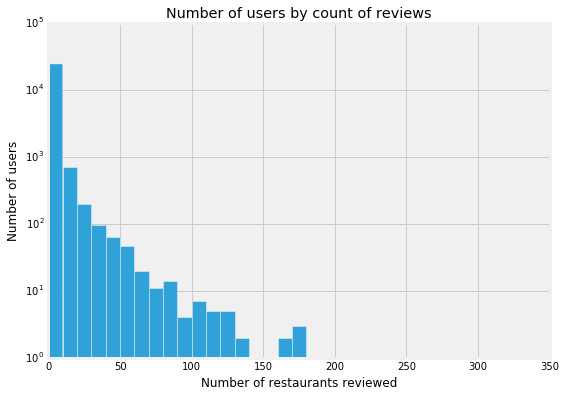

In [20]:
# plot review counts per user
plot_review_counts(M)

#### The utility matrix is sparse

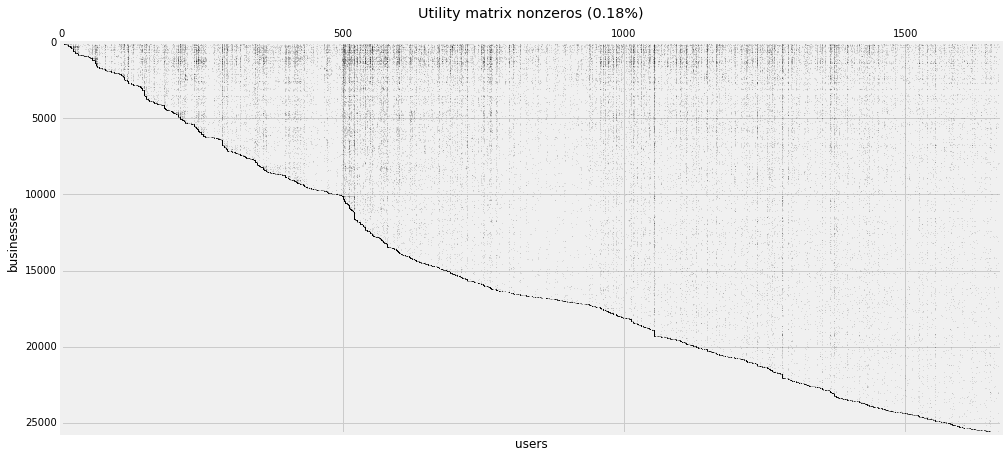

In [21]:
# plot utility matrix
plot_sparse_matrix(M)

In [22]:
# Testing will be done on users with reviews before and after the training/testing cut-off 
# Users with rating only after the cut-off will be disregarded since training on "future" 
# data is not realistic in a "real-world" setting.
# The utility matrix is constructed with the test indices masked off and the users with 
# ratings after the cut-off removed

def user_item_pair(dataframe, user_lookup, item_lookup, user_id_field, item_id_field):
    pairs = (dataframe[user_id_field].apply(lambda x: user_lookup[x]).values, 
             dataframe[item_id_field].apply(lambda x: item_lookup[x]).values)
    return pairs

def find_test_users(train_df, test_df):
    test_users_df = test_records.loc[test_records['user_id'].isin(train_records['user_id'].values)]
    discard_users_df = test_records.loc[~test_records['user_id'].isin(train_records['user_id'].values)]
    return test_users_df, discard_users_df

test_users, discard_users = find_test_users(train_records, test_records)
test_indx = user_item_pair(test_users, user_indx_lookup, business_indx_lookup, 'user_id', 'business_id')

In [498]:
# Normalize ratings by subtracting average user's rating
def row_mean(matrix,axis=1):
    # find row mean rating from utility matrix
    sums=np.squeeze(matrix.sum(axis).A)
    if axis == 1:
        counts = np.diff(matrix.indptr)
    else:
        counts = np.bincount(matrix.indices)
    means=sums/counts
    return means, counts


def plot_average_score(matrix, val, axis):
    avg, counts = row_mean(matrix, axis)
    fig=plt.figure()
    plt.hist(avg[avg>0],bins=np.arange(1,5,0.5))
    plt.title(''.join(['Average ',val, ' rating']))
    plt.xlabel('Star rating')
    plt.ylabel(''.join(['Number of  ',val, 's']))
    plt.show()
    

def normalize_utility(matrix):
    N = scipy.sparse.coo_matrix(matrix.shape)
    means, counts = row_mean(matrix)
    Mc = np.repeat(means, counts)
    (r,c,v)=scipy.sparse.find(matrix)
    N = scipy.sparse.coo_matrix((matrix.data.astype(np.float64) - Mc, (r, c)))
    return N

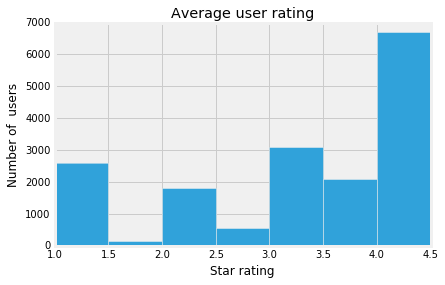

In [499]:
plot_average_score(M, 'user',1)

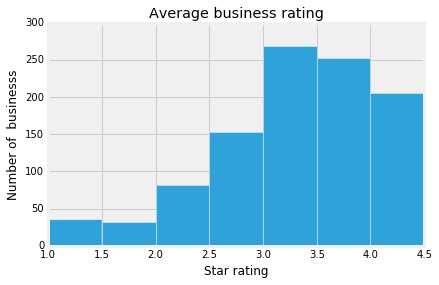

In [433]:
plot_average_score(M, 'business', 0)

### Test set

Evaluating the recommendation system will be done by comparing predicted star rating for users with reviews before and after the training/testing cut-off.

Users with rating only after the cut-off is disregarded, and not included in the utility matrix, since training on "future" data is not realistic in a "real-world" setting.

The utility matrix is constructed with the test indices masked off and the users with 
ratings after the cut-off removed

# Methods: Content-Based vs Collaborative Filtering Recommendation

## Content-Based

In content-based recommendation systems, profiles are created for items and for users.

Creating good profiles relies on designing (or learning) good features 

Predictions are based on similarities between items *or* similarities between users

## Collaborative Filtering

Instead of constructing item and user profiles, users are represented by their corresponding row in the utility matrix and items by their corresponding column. 

### Matrix factorization based predictions


User's rating of items are not random. They are goverened by ... *something*. We don't really know. Ratings could depend on many factors relating users, items, and external factors. 

We assume there are some (latent) factors that can be regarded as responsible for how users review restaurants. Without explicitly constructing these factors, we can construct matrices to represent them.


The utility matrix $R$ can be factorized in the following way

![factorization](factorization2.png)

$n$: number of users  
$m$: number of items (businesses)  
$k$: number of factors we allow for deciding ratings  


The goal is to factor the utility matrix to reduce the error

*i.e* find $P$ and $Q$ so that the error is minimized

Root mean square error

$ R \approx PQ$

prediction for user $i$ on item $j$: $S_{ij} = (PQ)_{ij}$

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i,j}\left|(s_{i,j} - r_{i,j})^2\right|}
$$



Instead of explicitly performing the $PQ$ multiplication, we can compute $S_{ij} = P_{i,:}Q_{:,j}$ only for non-zero values in the utility matrix

### Finding optimal $P$ and $Q$

##### Linear regression and least squares
In linear regression, we had a data matrix $\mathbf{X}$ and a target $\mathbf{y}$ and we wanted to find a coefficient vector $\mathbf{w}$ so that

$$ \mathbf{y} = \mathbf{X}\mathbf{w} + \lambda \mathbf{w}^T\mathbf{w} $$

<img src="linreg.PNG" width="200">

To find $\mathbf{w}$ that minimized the MSE $\left(MSE = \frac{1}{N} \displaystyle\sum_{n=1}^N (\mathbf{w}^T\mathbf{x}_n - y_n)^2 + \lambda\|\mathbf{w}\|_2^2 \right)$ there is a closed-formed solution:

$$
\mathbf{w} = \left(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^Ty
$$

##### Multivariable linear regression and least squares

If instead of predicting a single target value, we want to predict a vector for each instance $\mathbf{x}_i$,
we need to find a matrix of coefficients

<img src="multireg.PNG" width="300">

and the closed-form solution is 
$$
\mathbf{W} = \left(\mathbf{X}^T\mathbf{X} + \lambda\mathbf{I} \right)^{-1}\mathbf{X}^T\mathbf{Y}
$$

The multivariable regression problem 
$$\mathbf{Y}=\mathbf{X}\mathbf{W} + \lambda \|\mathbf{W}\|^2$$
looks very similar to the matrix factorization problem
$$
\mathbf{R} = \mathbf{P}\mathbf{Q} + \lambda\left(\|\mathbf{P}\|^2 + \|\mathbf{Q}\|^2\right)
$$ 

except in MF,  

**We don't know either of the matrices on the righthand side!**

Therefore the objective is non-convex


and the problem is NP-hard

#### Alternating least squares 

Using alternating least squares, we can fix one matrix, solve for the other, then use those values to fix the second matrix and solve for the first. We continue to alternate between solving both until the matrices converge

Repeat:  
* Fix $\mathbf{Q}$. Solve for $\mathbf{P}$  
    - $\mathbf{P} =\left(\mathbf{Q}\mathbf{Q}^T + \lambda\mathbf{I}\right)^{-1}\mathbf{Q}\mathbf{R}$
* Fix $\mathbf{P}$. Solve for $\mathbf{Q}$  
    - $\mathbf{Q} =\left(\mathbf{P}\mathbf{P}^T + \lambda\mathbf{I}\right)^{-1}\mathbf{P}\mathbf{R}^T$

Now, in each step the problem is just a multivariable linear regression where the feature matrix is $\mathbf{Q}$ (or $\mathbf{P}$) and the coefficient matrix is $\mathbf{P}$ (or $\mathbf{Q}$)

##### Note about regularization

modify the objective value to use weighted-$\lambda$-regularization<sup>1</sup> 
$$
\mathbf{R} = \mathbf{P}\mathbf{Q} + \lambda\left(\mathbf{n}_u
\|\mathbf{P}\|^2 + \mathbf{n}_b\|\mathbf{Q}\|^2\right)
$$

to include $n_u$, the number of businesses each user reviewed, and $n_b$, the number of users that reviewed each business 


Repeat:  
* Fix $\mathbf{Q}$. Solve for $\mathbf{P}$  
    - $\mathbf{P} =\left(\mathbf{Q}\mathbf{Q}^T + \mathbf{n}_u\lambda\mathbf{I}\right)^{-1}\mathbf{Q}\mathbf{R}$
* Fix $\mathbf{P}$. Solve for $\mathbf{Q}$  
    - $\mathbf{Q} =\left(\mathbf{P}\mathbf{P}^T + \mathbf{n}_b\lambda\mathbf{I}\right)^{-1}\mathbf{P}\mathbf{R}^T$

<sub><sup>[1] Zhou, Y. et al., 2008. Large-scale parallel collaborative filtering for the netflix prize. In Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics). pp. 337-348.</sup></sub>

In [25]:
# Nonzero and training indices to calculate RMSE without a full matrix product
test_indxs = list(zip(test_indx[0],test_indx[1]))
train_indxs = list(zip(R.nonzero()[0],R.nonzero()[1]))
validation_indxs = list(zip(*validation_indx))

In [169]:
# RMSE
def rmse(R,P,Q,lmbda, indices):
    n = R.shape[0]
    #n = len(indices)
    # predictions for indices (i,j)
    err_sum = 0
    for i,j in indices:
        prediction = P.T.getrow(int(i)).dot(Q.getcol(int(j))).data
        prediction = prediction[0]
        err_sum += (R[int(i),int(j)] - prediction)**2
    #err = np.sqrt(err_sum/n) + lmbda*((scipy.sparse.linalg.norm(P))**2 +(scipy.sparse.linalg.norm(Q))**2)
    err = np.sqrt(err_sum/n)
    return err

In [158]:
def alsq(R, M, k, lamda, max_iters, train_indxs, validation_indxs, test_indxs, **kwargs):

    n, m = R.shape 
     
    item_means, _ = row_mean(scipy.sparse.csc_matrix(R).T,axis=1)
    item_means[np.isnan(item_means)]=0
    user_means,_ = row_mean(R)
    user_means[np.isnan(user_means)]=0
    overall_mean = np.mean(item_means)
    
    # Initialize matrices
    # If P and Q were passed in, use those instead
    P = kwargs.get('P', None)
    Q = kwargs.get('Q', None)
    
    if Q is None or P is None:
        # Initialize matrices randomly
        P = scipy.sparse.csr_matrix(overall_mean * np.random.rand(k,n))
        Q = scipy.sparse.csr_matrix(overall_mean * np.random.rand(k,m))
        Q[0,:] = item_means + 0.000001 # Avg. rating for each item
    
    I = scipy.sparse.csr_matrix(scipy.sparse.coo_matrix((np.ones(len(R.nonzero()[0])),R.nonzero()),[n,m]))
    E = scipy.sparse.eye(k) # (k x k)-dimensional idendity matrix
   
    train_errors = []
    validation_errors = []
    test_errors = []
    
    for iter in range(max_iters):
        # Fix Q and estimate P
        for i, Ii in enumerate(I): # user i
            ni = len(Ii.nonzero()) # Number of items user i has rated
            if (ni == 0): ni = 1 

            Di = scipy.sparse.dia_matrix((np.array(Ii.todense()),[0]),shape=(m,m)) 
            Ai = Q.dot(Di.dot(Q.T)) + lmbda * ni * E
            bi = Q.dot(Di.dot(R.getrow(i).T))
            P[:,i] = scipy.sparse.linalg.spsolve(Ai,bi).reshape(k,1)

        # Fix P and estimate Q
        for j, Ij in enumerate(I.T): # business j
            nj = len(Ij.nonzero()) # Number of users that rated item j
            if (nj == 0): nj = 1 

            Dj = scipy.sparse.dia_matrix((np.array(Ij.todense()),[0]),shape=(n,n))
            Aj = P.dot(Dj.dot(P.T)) + lmbda * nj * E
            bj = P.dot(Dj.dot(R.getcol(j)))
            Q[:,j] = scipy.sparse.linalg.spsolve(Aj,bj).reshape(k,1)

        train_rmse = rmse(M,P,Q,lmbda, train_indxs)
        validation_rmse = rmse(M,P,Q,lmbda, validation_indxs)
        test_rmse = rmse(M,P,Q,lmbda, test_indxs)
        train_errors += [train_rmse]
        validation_errors += [validation_rmse]
        test_errors += [test_rmse]
        print("[Iteration {}/{}: train RMSE {}, validation RMSE {}, test RMSE {}]".format(iter+1, max_iters, train_rmse, validation_rmse, test_rmse))
        
    return P, Q, train_errors, validation_errors, test_errors

## Results

In [119]:
# Through cross validation, we will test pairs of regularization and dimensionality
from itertools import product

lmbdas = [0.1, 1, 2, 5, 10]
ks = [2, 5, 10, 20]
param_pairs = list(product(lmbdas, ks))
results = {p:{'train':[], 'validate':[], 'test':[],'P':None, 'Q':None} for p in param_pairs}

In [280]:
# The number of iterations will be fixed 
max_iters = 20

In [294]:
results = {p:{'train':[], 'validate':[], 'test':[],'P':None, 'Q':None} for p in param_pairs}

In [326]:
for lmbda, k in param_pairs:
    if (lmbda,k)not in results.keys() or results[(lmbda,k)]['P'] is None:
        print('lambda {}, k {}'. format(lmbda,k))
        P, Q, train_errors, validation_errors, test_errors = alsq(
            R, M, k, lmbda, max_iters, train_indxs, validation_indxs, test_indxs)
        results[(lmbda, k)] = {'train': train_errors, 
                                'validate': validation_errors,
                                'test': test_errors,
                                'P': P,
                                'Q': Q}

lambda 5, k 2
[Iteration 1/20: train RMSE 3.110945782088086, validation RMSE 1.4962039263643991, test RMSE 1.5381778214157509]
[Iteration 2/20: train RMSE 2.2319606259400837, validation RMSE 1.2514785329669016, test RMSE 1.3442927148632347]
[Iteration 3/20: train RMSE 2.0720930170066088, validation RMSE 1.1993932138703314, test RMSE 1.2997340387729424]
[Iteration 4/20: train RMSE 2.020959511903329, validation RMSE 1.182239546764226, test RMSE 1.2780946831626183]
[Iteration 5/20: train RMSE 2.003961204685282, validation RMSE 1.1762542179494468, test RMSE 1.2663021076618328]
[Iteration 6/20: train RMSE 1.9985774477750133, validation RMSE 1.1744357721269125, test RMSE 1.2594438569536164]
[Iteration 7/20: train RMSE 1.9972978359061795, validation RMSE 1.1742838684952777, test RMSE 1.2551062663128012]
[Iteration 8/20: train RMSE 1.9974686965314588, validation RMSE 1.1747077063049038, test RMSE 1.2521876988061313]
[Iteration 9/20: train RMSE 1.9980903628336695, validation RMSE 1.175254149387

In [327]:
# Save results to file
import pickle
with open('results.pickle', 'wb') as f:
    pickle.dump(results, f)

In [317]:
def plot_results_reg(results, lmbds, ks):
    # plot the results of all parameter values
    #ks =np.unique([k for l,k in results.keys()])
    #lmbds = np.unique([l for l,k in results.keys()])
    fig = plt.figure(figsize=(25,15))
    for i,k in enumerate(ks):
        
        #Training errors
        axTr = fig.add_subplot(3,len(ks),i+1)
        for l in lmbds:
            axTr.plot(results[(l,k)]['train'], label='$\lambda$={}'.format(l))
        if i == 0:
            plt.ylabel('Training RMSE')
        if i < len(ks):
            plt.title('k={}'.format(k))
        plt.legend()
        
        #Validation errors
        axV = fig.add_subplot(3,len(ks),len(ks)+i+1)
        for l in lmbds:
            axV.plot(results[(l,k)]['validate'], '--', label='$\lambda$={}'.format(l))
        if i == len(ks) :
            plt.ylabel('Validation RMSE')
        plt.legend()
        
        #Test errors
        axT = fig.add_subplot(3,len(ks),2*len(ks)+i+1)
        for l in lmbds:
            axT.plot(results[(l,k)]['test'], ':', label='$\lambda$={}'.format(l))
        plt.xlabel('k={}'.format(k))
        if i == 2*len(ks):
            plt.ylabel('Test RMSE')
        if i >= 2*len(ks):
            plt.ylabel('ALS iteration')
        plt.legend()
    plt.show()

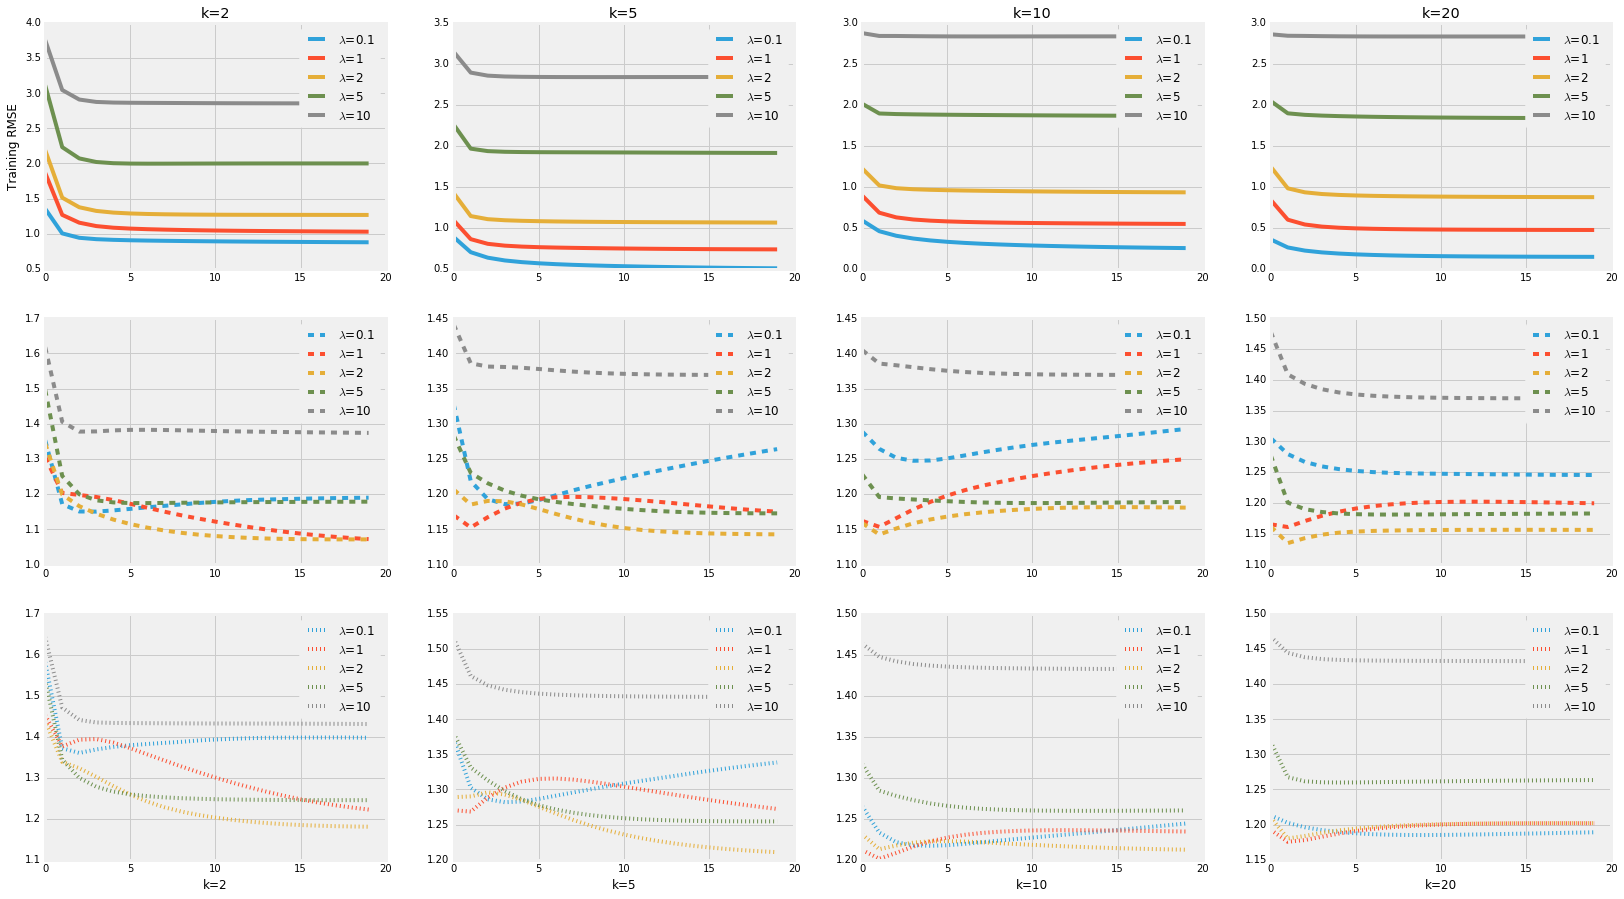

In [329]:
plot_results_reg(results,lmbdas,ks)

## Evaluate

#### Error measure
To evaluate the model, we compare the RMSE of this method with a simple baseline measure


$$
RMSE = \sqrt{\frac{1}{n} \sum_{i,j}\left|(s_{i,j} - r_{i,j})^2\right|}
$$

#### Baseline
The baseline always predicts the average rating for a particular item

In [146]:
def predict(P,Q,i,j):
    pred = P.T.getrow(int(i)).dot(Q.getcol(int(j))).data
    return pred   

In [599]:
# Baseline
R = scipy.sparse.csc_matrix(R,dtype=np.uint32) #fix sum overflow!!!
count_nnz = R.getnnz(0)
sums = np.array(R.sum(0)).flatten()
means = np.zeros(len(count_nnz))
for i,c in enumerate(count_nnz):
    if c != 0:
        means[i] = sums[i]/c
overall_mean = np.mean(means[means!=0])
means[means==0]=overall_mean
avg_errors = []
for i,j in test_indxs:
    actual = M[i,j]
    avg = means[j]
    if avg==0:
        avg = overall_mean
    avgerr = rmse_pred(actual, avg)
    avg_errors += [avgerr]
# Average Baseline error
bl_err = np.mean(avg_errors)
print('Average Baseline MSE: {:.4f}'.format(bl_err))

Average Baseline MSE: 1.1550


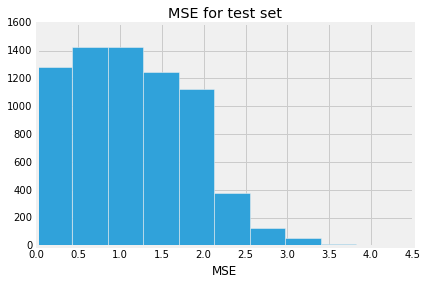

In [603]:
plt.figure()
plt.hist(avg_errors)
plt.xlabel('MSE')
plt.title('MSE for test set')

In [83]:
def rmse_pred(actual, predicted):    
    err_sum = (actual - predicted)**2
    return err_sum

In [521]:
#Calculate MSE for each parameter pair
MF_errors = {(l,k):[] for l,k in results.keys()}
MFVal_errors = {(l,k):[] for l,k in results.keys()}

#Matrix Factorization            
for l,k in param_pairs:
    if results[(l,k)]['P'] is not None:
        P = results[(l,k)]['P']
        Q = results[(l,k)]['Q']
        
        for i,j in validation_indxs:        
            actual = M[i,j]
            MF = predict(P,Q,i,j)
            MFerr = rmse_pred(actual, MF)
            if len(MFerr)>0:
                MFVal_errors[l,k] += [MFerr[0]]

        for i,j in test_indxs:        
            actual = M[i,j]
            MF = predict(P,Q,i,j)
            MFerr = rmse_pred(actual, MF)
            if len(MFerr)>0:
                MF_errors[l,k] += [MFerr[0]]
                
        valerr = np.sqrt(np.sum(MFVal_errors[l,k])/len(MFVal_errors[l,k]))
        testerr = np.sqrt(np.sum(MF_errors[l,k])/len(MF_errors[l,k]))
        print('lambda = {}, k = {} \t| val error {:.4f} \t| test error {:.4f}'.format(l,k,valerr, testerr))
       

lambda = 0.1, k = 2 	| val error 1.0147 	| test error 1.2590
lambda = 0.1, k = 5 	| val error 1.0973 	| test error 1.2806
lambda = 0.1, k = 10 	| val error 1.1478 	| test error 1.2269
lambda = 0.1, k = 20 	| val error 1.1303 	| test error 1.1761
lambda = 1, k = 2 	| val error 0.9807 	| test error 1.1531
lambda = 1, k = 5 	| val error 1.0564 	| test error 1.2341
lambda = 1, k = 10 	| val error 1.1174 	| test error 1.2155
lambda = 1, k = 20 	| val error 1.0953 	| test error 1.1896
lambda = 2, k = 2 	| val error 0.9940 	| test error 1.1375
lambda = 2, k = 5 	| val error 1.0471 	| test error 1.1889
lambda = 2, k = 10 	| val error 1.0767 	| test error 1.1943
lambda = 2, k = 20 	| val error 1.0682 	| test error 1.1877
lambda = 5, k = 2 	| val error 1.0715 	| test error 1.2309
lambda = 5, k = 5 	| val error 1.0663 	| test error 1.2385
lambda = 5, k = 10 	| val error 1.0795 	| test error 1.2454
lambda = 5, k = 20 	| val error 1.0749 	| test error 1.2492
lambda = 10, k = 2 	| val error 1.1944 	

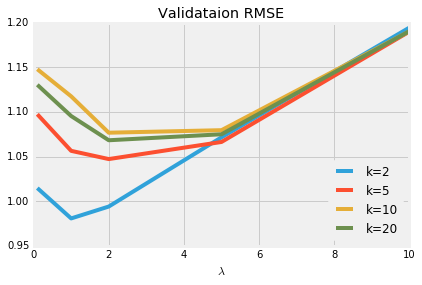

In [339]:
#effect of lambda
fig = plt.figure()
for k in ks:
    errs = [np.sqrt(np.sum(MFVal_errors[l,k])/len(MFVal_errors[l,k])) for l in lmbdas]
    plt.plot(lmbdas,errs,label='k={}'.format(k))
plt.legend(loc=4)
plt.title('Validataion MSE')
plt.xlabel('$\lambda$')

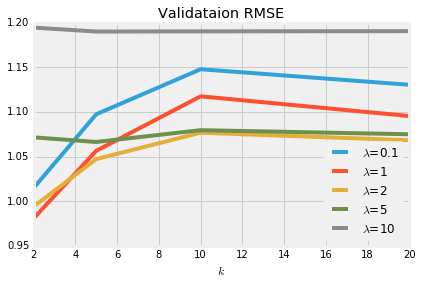

In [342]:
#effect of k
fig = plt.figure()
for l in lmbdas:
    errs = [np.sqrt(np.sum(MFVal_errors[l,k])/len(MFVal_errors[l,k])) for k in ks]
    plt.plot(ks,errs,label='$\lambda$={}'.format(l))
plt.legend(loc=4)
plt.title('Validataion MSE')
plt.xlabel('$k$')